In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import torch
import torch.nn.functional as F

from networkx.algorithms.dag import topological_sort

%matplotlib inline

In [0]:
class wann:
  def __init__(self, input_dim, num_classes):
    """
    Initializes a WANN with no connections.
    Each node is an integer.
    """
    self.input_dim = input_dim
    self.num_classes = num_classes
    self.hidden = 0
    self.g = nx.DiGraph()
    self.activations = {}

    for i in range(input_dim):
      v = "i" + str(i)
      self.g.add_node(v)
      self.activations[v] = None
    for i in range(num_classes):
      v = "o" + str(i)
      self.g.add_node(v)
      self.activations[v] = None
  
  def edge_count(self):
    return self.g.size()
  
  def copy(self):
    """
    Copies WANN.
    """
    copy = wann(self.input_dim, self.num_classes)
    copy.hidden = self.hidden
    copy.g = self.g.copy()
    copy.activations = dict(self.activations)
    return copy

  def add_node(self, u, v, activation):
    """
    Splits the edge u->v to u->x->v and sets activation of node x.
    """
    x = self.hidden
    self.hidden += 1
    self.g.add_node(x)
    self.g.remove_edge(u, v)
    self.g.add_edge(u, x)
    self.g.add_edge(x, v)
    self.activations[x]=activation
  
  def add_edge(self, u, v):
    """
    Adds edge u->v.
    """
    self.g.add_edge(u, v)
  
  def change_activation(self, v, activation):
    """
    Changes activation of node v.
    """
    self.activations[v] = activation
  
  def mutate(self, num_children, activations=[torch.sigmoid, F.relu, F.tanh]):
    """
    Returns a list of children.
    """
    children = []
    edges = list(nx.edges(self.g))
    non_edges = []
    for i in range(self.input_dim):
      v = "i" + str(i)
      for j in range(self.hidden):
        non_edges.append((v, j))
      for j in range(self.num_classes):
        non_edges.append((v, "o" + str(j)))
    for i in range(self.hidden):
      for j in range(self.hidden):
        if i != j:
          non_edges.append((i, j))
      for j in range(self.num_classes):
        non_edges.append((i, "o" + str(j)))
    
    for i in range(num_children):
      child = self.copy()

      if self.hidden >= 1:
        upper = 3
      else:
        upper = 2
      if self.edge_count() >= 1:
        lower = 1
      else:
        lower = 2
      
      r = random.randint(lower, upper)

      if r == 1:
        # split edge into node and two edges
        edge = random.choice(edges)
        child.add_node(edge[0], edge[1], random.choice(activations))
      elif r == 2:
        # add random edge
        edge = random.choice(non_edges)
        while nx.has_path(self.g, edge[1], edge[0]):
          edge = random.choice(non_edges)
        child.add_edge(edge[0], edge[1])
      else:
        # change activation
        v = random.randint(0, self.hidden - 1)
        a = self.activations[v]
        activations.remove(a)
        child.change_activation(v, random.choice(activations))
        activations.append(a)
      children.append(child)
    return children
  
  def forward(self, batch, weight):
    """
    Calculates forward pass using shared weight.
    Softmax at end for probabilities of each class.
    """
    assert len(batch.shape) == 2 and batch.shape[1] == self.input_dim

    output = {i: torch.zeros(batch.shape[0]) for i in range(self.hidden)}
    for i in range(self.input_dim):
      output["i" + str(i)] = batch[:,i]
    for i in range(self.num_classes):
      output["o" + str(i)] = torch.zeros(batch.shape[0])

    for v in topological_sort(self.g):
      activation = self.activations[v]
      if activation is not None:
        output[v] = activation(output[v])
      for w in self.g.neighbors(v):
        output[w] += weight * output[v]
    
    final = torch.stack(tuple(output["o" + str(i)] for i in range(self.num_classes))).transpose(0, 1)
    return F.softmax(final, dim=1)
  
  def visualize(self):
    """
    Creates diagram of WANN.
    """
    if self.hidden >= 1:
      hidden_x = [1] * self.hidden
      for i in range(self.input_dim):
        for v, pl in nx.single_source_shortest_path_length(self.g, "i" + str(i)).items():
          if isinstance(v, int):
            hidden_x[v] = max(hidden_x[v], pl)

      layers = [[] for i in range(max(hidden_x) + 1)]
      layers[0] = ["i" + str(i) for i in range(self.input_dim)]
      for i in range(self.hidden):
        layers[hidden_x[i]].append(i)
      layers.append(["o" + str(i) for i in range(self.num_classes)])
    else:
      layers = [["i" + str(i) for i in range(self.input_dim)], ["o" + str(i) for i in range(self.num_classes)]]

    pos = {}
    for x in range(len(layers)):
      y = (1 - len(layers[x])) // 2
      for v in layers[x]:
        pos[v] = (x, y)
        y += 1

    labels = {}
    for i in range(self.hidden):
      if self.activations[i] is None:
        labels[i] = "None"
      else:
        labels[i] = self.activations[i].__name__
    for i in range(self.input_dim):
      labels["i" + str(i)] = "i" + str(i)
    for i in range(self.num_classes):
      labels["o" + str(i)] = "o" + str(i)
    
    nx.draw(self.g, with_labels=True, pos=pos, labels=labels)
    

tensor([[1.7668e-02, 1.7668e-02, 9.6466e-01],
        [3.7751e-11, 3.7751e-11, 1.0000e+00]])


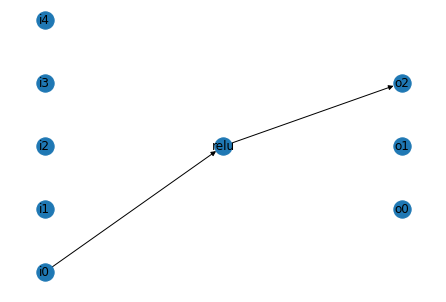

In [13]:
w = wann(5,3)
w.add_edge("i0", "o2")
w.add_node("i0", "o2", F.relu)
print(w.forward(torch.FloatTensor([[1,2,3,4,5],[6,7,8,9,10]]), 2))
w.visualize()

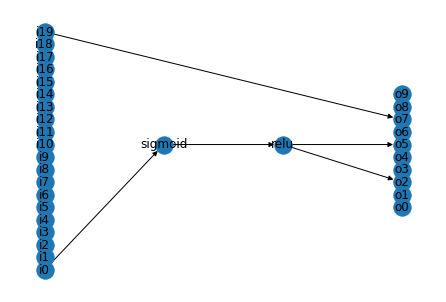

In [14]:
w = wann(20,10)
w.add_edge("i0", "o2")
w.add_node("i0", "o2", F.relu)
w.add_edge("i19", "o7")
w.add_edge(0, "o5")
w.add_node("i0", 0, torch.sigmoid)
w.visualize()

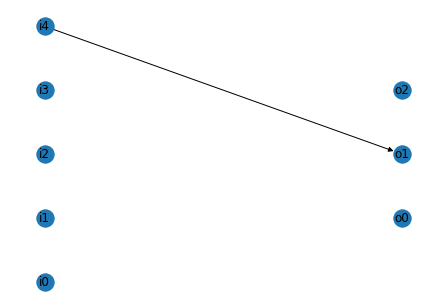

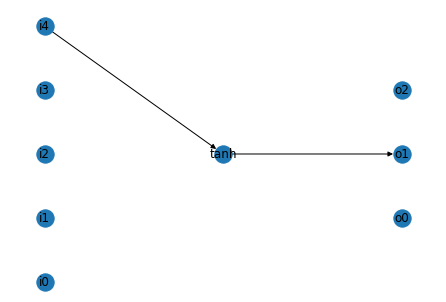

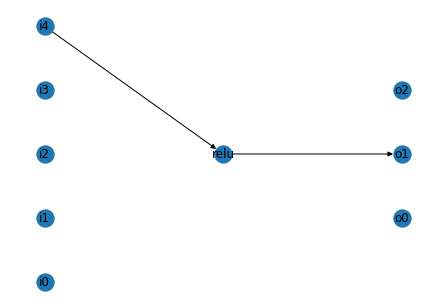

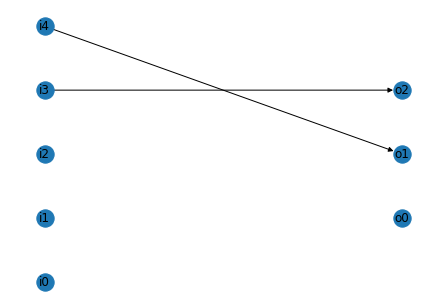

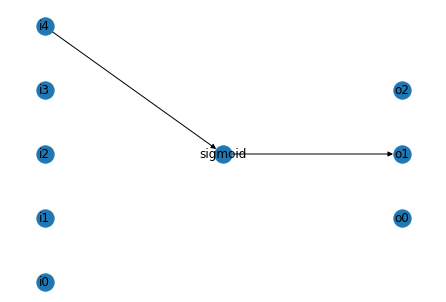

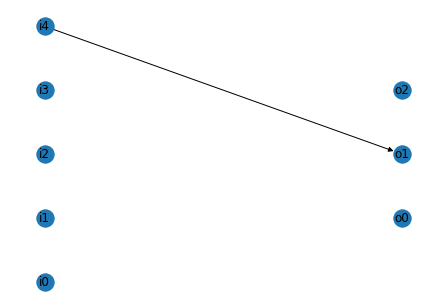

In [71]:
w = wann(5,3)

a = w.mutate(1)
plt.figure(0)
a[0].visualize()

b = a[0].mutate(5)
for i in range(len(b)):
  plt.figure(i + 1)
  b[i].visualize()